# Leigh Ann Kudloff and Nataly Valenzuela Mullen 
# Final Project--Data Science Tools 1  
# Winter 2021

## I.	Introduction/Story
### Like most Data Science students, concern about job opportunities in the near future loom heavily at the halfway point of this degree program.  In one year, employment is necessary to pay off student loans and enter the world of data science.  This project focuses on the world of job hunting in Data Science.  The goal is to explore job descriptions to categorize skill sets, look for patterns, and prepare tools for the job hunt later this year.  Through the exploration of trends in data science job postings, the concepts learned from Data Science Tools 1 and other classes will be applied and hopefully the ideal jobs will emerge.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pandas_profiling  as pp
import plotly.express    as px
import re

from mpl_toolkits.mplot3d    import Axes3D
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance  import pdist
from sklearn                 import datasets
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA
from sklearn.metrics         import confusion_matrix

import string
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

In [2]:
df1 = pd.read_csv("DataScienceJobs.csv")

df1 = df1[["Job Title", "Job Description", "Company Name", "City", "State", "Size", 
           "Years_Founded", "Industry", "Rating", "Min_Salary", "Max_Salary", "Est_Salary"]]

strCols = df1.select_dtypes(['object']).columns
df1[strCols] = df1[strCols].apply(lambda x: x.str.strip())

# Used this code to adjust UK jobs for US:  
                                            #df1[df1.State.isin(["United Kingdom"])]
                                            #df1.iloc[1870]["Job Description"]
df1.iloc[1637,3]="Upper Providence"
df1.iloc[1784,3]="Upper Providence"
df1.iloc[1799,3]="Upper Providence"
df1.iloc[1870,3]="Philadelphia"
df1.iloc[[1637, 1784, 1799, 1870], 4]="PA"

# Create Location by joining columns--City and State
df1["Location"]=df1["City"] +", " + df1["State"]

# Creating a column for Remote work
df1.loc[df1["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df1["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1_to_50_employees": "Very Small", 
           "51_to_200_employees": "Small",
          "201_to_500_employees": "Medium-Small",
          "501_to_1000_employees": "Medium",
          "1001_to_5000_employees": "Medium-Large",
          "5001_to_10000_employees": "Large",
          "10000_employees": "Very Large"}
df1["Size"].replace(sizeKey, inplace=True)

df1.rename({"Min_Salary": "SalaryMin", "Max_Salary": "SalaryMax", "Est_Salary": "Salary Estimate"}, 
                  axis=1, inplace=True)

#Changing Years_Founded to Founded
df1["Founded"]=2020-df1["Years_Founded"]
df1.drop(["Years_Founded"], axis=1, inplace=True)

# Removing underscores from Industry
df1["Industry"]=df1["Industry"].replace("_", " ", regex=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF1=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF1duplicates=df1[df1.duplicated(criteriaDF1)].sort_values(by=criteriaDF1)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df1=df1[~df1.duplicated(criteriaDF1)]

# Dataframe Label
df1["DF"]= "DF1"

# Reordered Columns for Readability
df1 = df1.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote", 
                                             "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df1.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

print(DF1duplicates.shape)
print(df1.shape)
#df1.head(10)
#df1.State.value_counts()
list(df1.Size.unique())
df1.sample(10)

(21, 14)
(12339, 15)


Job Title  \
5152                                 Senior Data Analyst   
1888                          TECAN Automation Scientist   
828                         Data Engineer - QuantumBlack   
5305   Data Platform System Analyst Lead (Data Services)   
2132                      Scientist, Product Development   
10698                        Business Operations Analyst   
3606                  Data Engineer - Guidewire Data Hub   
11212                            IS Analyst/Programmer I   
7173                                       Data Engineer   
5929                         Senior Product Data Analyst   

                                         Job Description  \
5152   Description:\n\nBorn digital, Axos Bank has re...   
1888   TECAN Automation Scientist\n\nSalary:\nHighly ...   
828    You will be working on the frameworks and libr...   
5305   Qualifications:+ This role requires a wide var...   
2132   Those who join Emergent BioSolutions feel a se...   
10698  Business Operations Analyst**job details:**+ l...   
3606   Data Engineer- Guidewire Data HubJacksonville,...   
11212  Overview\n\n\nThis position is open until fill...   
7173   SUMMARYData Analytics team is looking for a sm...   
5929   Since 2005, BOLD has established itself as a j...   

                                   Company Name             Location  \
5152                                  Axos Bank        San Diego, CA   
1888                                ProClinical     Collegeville, PA   
828                          McKinsey & Company          Chicago, IL   
5305                             JPMorgan Chase       Lewisville, TX   
2132                      Emergent BioSolutions        San Diego, CA   
10698                                  Randstad      San Antonio, TX   
3606   American Recruiting and Consulting Group     Jacksonville, FL   
11212                  Sdsu Research Foundation        San Diego, CA   
7173                               Numeric, LLC  King of Prussia, PA   
5929                                       BOLD    San Francisco, CA   

                  City State     Remote          Size  Founded  \
5152         San Diego    CA  Uncertain  Medium-Large   2000.0   
1888      Collegeville    PA  Uncertain         Small   2005.0   
828            Chicago    IL  Uncertain    Very Large   1926.0   
5305        Lewisville    TX  Uncertain    Very Large   1799.0   
2132         San Diego    CA  Uncertain  Medium-Large   1998.0   
10698      San Antonio    TX        Yes  Medium-Large      NaN   
3606      Jacksonville    FL        Yes         Small   1982.0   
11212        San Diego    CA  Uncertain  Medium-Large      NaN   
7173   King of Prussia    PA  Uncertain    Very Small      NaN   
5929     San Francisco    CA  Uncertain  Medium-Small   2004.0   

                                  Industry  Rating  SalaryMin  SalaryMax  \
5152                   Banks Credit Unions     3.4         76        122   
1888                  Staffing Outsourcing     3.8         68         89   
828                             Consulting     4.4         39         81   
5305   Investment Banking Asset Management     3.9         44         82   
2132               Biotech Pharmaceuticals     3.0        114        146   
10698                 Staffing Outsourcing     3.6         53        102   
3606                  Staffing Outsourcing     5.0         66        130   
11212              Grantmaking Foundations     4.2         73        112   
7173                  Staffing Outsourcing     3.2         94        166   
5929                              Internet     3.6         46         86   

       Salary Estimate   DF  
5152              99.0  DF1  
1888              78.5  DF1  
828               60.0  DF1  
5305              63.0  DF1  
2132             130.0  DF1  
10698             77.5  DF1  
3606              98.0  DF1  
11212             92.5  DF1  
7173             130.0  DF1  
5929              66.0  DF1

In [3]:
df2 = pd.read_csv("DataScientist.csv")

df2 = df2[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = df2.select_dtypes(['object']).columns
df2[strCols] = df2[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# df2[df2.State.isin(["United Kingdom"])]
#print(df2.State.value_counts())
#print(df2[df2.State.isin([" United Kingdom"])])

df2.iloc[1647,3]="Upper Providence, PA"
df2.iloc[1794,3]="Upper Providence, PA"
df2.iloc[1809,3]="Upper Providence, PA"
df2.iloc[1880,3]="Philadelphia, PA"

# Split Location into new columns--City and State
df2[["City", "State"]]= df2["Location"].str.split(",", n = 1, expand = True)
df2.loc[(~df2["Location"].str.contains(",")), "State"]=df2.loc[(~df2["Location"].str.contains(",")),"City"]
df2["State"]=df2["State"].str.strip()
df2.loc[(~df2["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
df2.loc[(df2["Location"]=="Remote"), "Remote"]="Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
df2.loc[(df2["Location"]=="Remote"), "State"]=np.nan

# Creating a column for Remote work
df2.loc[df2["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
df2[["SalaryTest", "Salary"]] = df2["Salary Estimate"].str.split("(", n = 1, expand = True)
df2[["SalaryMin", "SalaryMax"]]= df2["SalaryTest"].str.split("-", n = 1, expand = True)
df2.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
df2["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
df2["SalaryMin"]=df2["SalaryMin"].replace("[$K]","",regex=True)
df2["SalaryMax"]=df2["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
df2["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
df2[["Company Name", "RateTest"]] = df2["Company Name"].str.split("\n", n=1, expand = True)
df2.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF2=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF2duplicates=df2[df2.duplicated(criteriaDF2)].sort_values(by=criteriaDF2)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df2=df2[~df2.duplicated(criteriaDF2)]

# Dataframe Label
df2["DF"]= "DF2"

# Reordered Columns for Readability
df2 = df2.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote",
                              "Size", "Founded", "Industry", "Rating", "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df2.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

#print(DF2duplicates.shape)
print(df2.shape)
df2.sample(10)

(3909, 15)


Job Title  \
3747                      Marketing Data Scientist   
2848                                Data Scientist   
241     Machine Learning Engineer, Computer Vision   
197                       Principal Data Scientist   
1992                       Associate Data Engineer   
1459                                 Data Engineer   
2327  Director, Data Sciences, Non Clinical Safety   
1538                       Big Data Engineer/Admin   
1116                                  Data Analyst   
1031                                 Data Engineer   

                                        Job Description  \
3747  Why Choose A Career with Designer Brands?\n\n\...   
2848  The Opportunity\n\nEversight is the recognized...   
241   This role is part of the Core team within the ...   
197   Pizza is at the heart of our communities. From...   
1992  Great sales are the result of strong purpose, ...   
1459  Our client in Phoenix, AZ is looking to add dy...   
2327  Janssen Research & Development LLC, a Johnson ...   
1538  NOTE: ONLY GREEN CARD HOLDERS and U.S. CITIZEN...   
1116  Research emerging tech. Find new trends. Creat...   
1031  This is an exciting opportunity to join an inn...   

                              Company Name         Location         City  \
3747                                   DSW     Columbus, OH     Columbus   
2848                             Eversight    Palo Alto, CA    Palo Alto   
241                           Samsung NEXT     New York, NY     New York   
197                             Slice (NY)     New York, NY     New York   
1992                             OptumCare  San Antonio, TX  San Antonio   
1459                       VincentBenjamin      Phoenix, AZ      Phoenix   
2327               J&J Family of Companies     La Jolla, CA     La Jolla   
1538  Allstate Insurance - 1202 Irving, TX        Tempe, AZ        Tempe   
1116                   Houston Exponential      Houston, TX      Houston   
1031           Informatic Technologies Inc      Chicago, IL      Chicago   

     State     Remote          Size  Founded  \
3747    OH  Uncertain    Very Large   1969.0   
2848    CA  Uncertain         Small   2013.0   
241     NY  Uncertain  Medium-Small   2012.0   
197     NY  Uncertain         Small   2010.0   
1992    TX  Uncertain        Medium      NaN   
1459    AZ  Uncertain         Small      NaN   
2327    CA  Uncertain    Very Large   1887.0   
1538    AZ  Uncertain           NaN      NaN   
1116    TX  Uncertain           NaN      NaN   
1031    IL  Uncertain    Very Small      NaN   

                                     Industry  Rating SalaryMin SalaryMax  \
3747      Department, Clothing, & Shoe Stores     3.3       100      163    
2848  Enterprise Software & Network Solutions     4.2        93      149    
241              Computer Hardware & Software     3.0       116      152    
197                                  Internet     4.0       119      147    
1992         Health Care Services & Hospitals     3.4        54       92    
1459                   Staffing & Outsourcing     3.4        64       97    
2327                Biotech & Pharmaceuticals     4.0        88      140    
1538                                      NaN     NaN        97      111    
1116                                      NaN     NaN        36       71    
1031                                      NaN     5.0        69      144    

      Salary Estimate   DF  
3747              NaN  DF2  
2848              NaN  DF2  
241               NaN  DF2  
197               NaN  DF2  
1992              NaN  DF2  
1459              NaN  DF2  
2327              NaN  DF2  
1538              NaN  DF2  
1116              NaN  DF2  
1031              NaN  DF2

In [4]:
# column selection--unnecessary columns eliminated
dfGlassdoor = pd.read_csv("glassdoor_jobs.csv")
# print(list(dfGlassdoor.columns))
dfGlassdoor.drop(['Headquarters', 'Sector', 'Revenue', 'Competitors', 'Type of ownership'],axis = 1, inplace = True)

strCols = dfGlassdoor.select_dtypes(['object']).columns
dfGlassdoor[strCols] = dfGlassdoor[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# dfGlassdoor[dfGlassdoor.State.isin (["None", " Raleigh", " Anne Arundel, MD"])])

dfGlassdoor.iloc[297,5]="Patuxent, MD"
dfGlassdoor.iloc[136,5]="Raleigh, NC"
dfGlassdoor.iloc[320,5]="Remote"
dfGlassdoor.iloc[12,5]="Portland, OR"
dfGlassdoor.iloc[157,5]="Chicago, IL"
dfGlassdoor.iloc[163,5]="Pembroke Pines, Florida"
dfGlassdoor.iloc[11,5]="Holmdel, NJ"
dfGlassdoor.iloc[346,5]="Middlesex, NJ"
dfGlassdoor.iloc[757,5]="Arlington, VA"
dfGlassdoor.iloc[758,5]="Hollywood, CA"
dfGlassdoor.iloc[830,5]="Washington, DC"

# Split Location into new columns--City and State and make city nan
dfGlassdoor[["City", "State"]]= dfGlassdoor["Location"].str.split(",", n = 1, expand = True)
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "State"]=dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")),"City"]
dfGlassdoor["State"]=dfGlassdoor["State"].str.strip()
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "Remote"]="Yes"
dfGlassdoor["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfGlassdoor.loc[dfGlassdoor["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfGlassdoor[["SalaryTest", "Salary"]] = dfGlassdoor["Salary Estimate"].str.split("(", n = 1, expand = True)
dfGlassdoor[["SalaryMin", "SalaryMax"]]= dfGlassdoor["SalaryTest"].str.split("-", n = 1, expand = True)
dfGlassdoor.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfGlassdoor["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfGlassdoor["SalaryMin"]=dfGlassdoor["SalaryMin"].replace("[$K]","",regex=True)
dfGlassdoor["SalaryMax"]=dfGlassdoor["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfGlassdoor["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfGlassdoor[["Company Name", "RateTest"]] = dfGlassdoor["Company Name"].str.split("\n", n=1, expand = True)
dfGlassdoor.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaGD=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#GDduplicates=dfGlassdoor[dfGlassdoor.duplicated(criteriaGD)].sort_values(by=criteriaGD)
#testGD=GDduplicates.loc[GDduplicates["SalaryMin"].notnull()]
dfGlassdoor=dfGlassdoor[~dfGlassdoor.duplicated(criteriaGD)]

# Dataframe Label
dfGlassdoor["DF"]= "GD"

# Reordered Columns for Readability
dfGlassdoor = dfGlassdoor.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfGlassdoor.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfGlassdoor.fillna(value=np.nan, axis=1, inplace=True)
#dfGlassdoor["Founded"]=dfGlassdoor["Founded"].astype(int)--We found this did not work well.

#print(testGD.shape)
print(dfGlassdoor.shape)
dfGlassdoor.sample(20)


(899, 15)


Job Title  \
520                                  Data Scientist   
137  Business Intelligence Analyst I- Data Insights   
516                                    Data Analyst   
710                                  Data Scientist   
172                            Chief Data Scientist   
748            Senior Data Scientist - R&D Oncology   
832                                  Data Scientist   
690                                  Data Scientist   
686                                  Data Scientist   
823                                   Data Engineer   
436                                  Data Scientist   
563                                  Data Scientist   
98                                   Data Scientist   
873                                  Data Scientist   
562                                  Data Scientist   
542                                  Data Scientist   
843                                  Data Scientist   
82               Senior Data & Analytics Consultant   
392                                  Data Scientist   
150                         Computational Scientist   

                                       Job Description  \
520  Description\n\nThe Data Scientist is responsib...   
137  Position Summary\n\nIndividuals within the\nBu...   
516  Data Analyst/SQL Developer, St. Louis, MO\n\nA...   
710  Role Description\nAs a data scientist at Tripl...   
172  Position overview:\n\nTeaching Strategies is t...   
748  At AstraZeneca,we work together to deliver inn...   
832  Why TrueAccord?\n\nDebt collection is failing ...   
690  LOCATION: Remote (home based) with some travel...   
686  Overview\n\n\nAt Sotheby’s we use data science...   
823  MongoDB is the leading modern, general purpose...   
436  Transforming the future of healthcare isn't so...   
563  We are seeking an experienced Data Scientist t...   
98   As a Data Scientist, you'll utilize advanced q...   
873  Work experience as a Python Developer\nExperti...   
562  Avenue Code is an eCommerce consulting firm he...   
542  Home » New Job from Competentia\nData Scientis...   
843  Knowledge Services is seeking a Data Scientist...   
82   We are seeking a Senior Data & Analytics Consu...   
392  GRT Corporation is seeking a highly motivated,...   
150  Type of Requisition:\n\nRegular\n\nClearance L...   

                                Company Name           Location  \
520                        Burns & McDonnell    Kansas City, MO   
137                            Guardian Life       Appleton, WI   
516                             Envision LLC    Saint Louis, MO   
710                               Triplebyte  San Francisco, CA   
172                 Teaching Strategies, LLC       Bethesda, MD   
748                              AstraZeneca       New York, NY   
832                               TrueAccord             Remote   
690                         Pivotal Software     Washington, DC   
686                                Sotheby's       New York, NY   
823                                  MongoDB       New York, NY   
436                        Change Healthcare        Lombard, IL   
563                           Latitude, Inc.         Dayton, OH   
98                        Via Transportation       New York, NY   
873                               TransReach  San Francisco, CA   
562                           avenuecode.com  San Francisco, CA   
542                      Competentia Holding        Houston, TX   
843                       Knowledge Services   Indianapolis, IN   
82               Corporate Technologies Inc.     Burlington, MA   
392                          GRT Corporation       Hartford, CT   
150  General Dynamics Information Technology      Vicksburg, MS   

              City State     Remote          Size  Founded  \
520    Kansas City    MO  Uncertain         Large   1898.0   
137       Appleton    WI  Uncertain         Large   1860.0   
516    Saint Louis    MO  Uncertain  Medium-Small   1994.0   
710  San Fr

In [5]:
dfIndeed = pd.read_csv("df_all_indeed.csv")

dfIndeed.drop(['Unnamed: 0','Easy_Apply'],axis = 1, inplace = True)

strCols = dfIndeed.select_dtypes(['object']).columns
dfIndeed[strCols] = dfIndeed[strCols].apply(lambda x: x.str.strip())

dfIndeed.iloc[[57, 114, 231,3521,3632,3637,3961],2]="Carlsbad, NM"
dfIndeed.iloc[[3520, 3578, 3661,3666,3776, 3843, 3967],2]="Spring, TX"
dfIndeed.iloc[3772, 2]="Panama City, FL"
dfIndeed.iloc[[1607, 1765, 1801],2]="New York, NY"
dfIndeed.iloc[[557, 665],2]="Remote"
dfIndeed.iloc[[410,1484],2]="San Diego, CA"
dfIndeed.iloc[418, 2]="Los Angelos, CA"
dfIndeed.iloc[82, 2]="Denver, CO"
dfIndeed.iloc[[1009, 1327],2]="Menlo Park, CA"

dfIndeed[["City", "State"]]= dfIndeed["Locations"].str.split(",", n = 1, expand = True)
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "State"]=dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")),"City"]
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "Remote"]="Yes"
dfIndeed["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfIndeed.loc[(dfIndeed["Summary"].str.contains("Remote|remote")==True), "Remote"]= "Yes"
dfIndeed.loc[(dfIndeed["Jobs"].str.contains("Remote|remote")==True), "Remote"]= "Yes"

dfIndeed.rename({"Summary": "Job Description", "Companies": "Company Name", "Jobs": "Job Title", "Locations": "Location"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaIN=["Company Name", "Job Title", "City", "State", "Job Description"]
INduplicates=dfIndeed[dfIndeed.duplicated(criteriaIN)].sort_values(by=criteriaIN)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfIndeed=dfIndeed[~dfIndeed.duplicated(criteriaIN)]

# Dataframe Label
dfIndeed["DF"]= "IN"

# Reordered Columns for Readability
dfIndeed = dfIndeed.reindex(columns = ["Job Title", "Job Description", "Company Name", 
                                       "Location", "City", "State", "Remote", "Rating", "DF"])
#print(INduplicates.shape)
print(dfIndeed.shape)
dfIndeed.head(10)

(2871, 9)


Job Title  \
0                               Data Science Modeler   
1                   Director Integrated Data Science   
2                                     Data Scientist   
3                                     Data Scientist   
4               Sr Business Analyst / Data Scientist   
5                                      Data Engineer   
6                                     Data Scientist   
7                                     Data Scientist   
8                               Data Science Analyst   
9  Senior Applications Scientist, Bioinformatics/...   

                                     Job Description          Company Name  \
0  As a Data Science Modeler, you will be a key p...                 Avero   
1  Demonstrated knowledge of programming expertis...                  UPMC   
2  University bachelor’s degree in data science, ...  Willis Towers Watson   
3  Effectively represent the Data Science group i...       Valen Analytics   
4  See the data “forest for the trees” and help i...               PHOENIX   
5  Troubleshoot basic data and data engineering i...       Valen Analytics   
6  Data scientists use data and analytical abilit...            Horizontal   
7  Data Science: 3 years (Preferred). Data scient...             Pricesenz   
8  Data Engineer Tech – :Cleaning and Integrating...   xentity corporation   
9  Expertise in probability & statistics, machine...             Inscripta   

         Location        City State     Remote  Rating  DF  
0     Boulder, CO     Boulder    CO  Uncertain     2.6  IN  
1    Loveland, CO    Loveland    CO  Uncertain     3.7  IN  
2      Denver, CO      Denver    CO  Uncertain     3.7  IN  
3      Denver, CO      Denver    CO  Uncertain     NaN  IN  
4      Denver, CO      Denver    CO  Uncertain     NaN  IN  
5      Denver, CO      Denver    CO  Uncertain     NaN  IN  
6  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
7  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
8      Denver, CO      Denver    CO  Uncertain     4.6  IN  
9     Boulder, CO     Boulder    CO  Uncertain     3.0  IN

In [6]:
dfLinkedIn = pd.read_csv("df_all_linkedin.csv")

dfLinkedIn.drop(['Unnamed: 0','Number_of_Applicants', 'Length_of_Description', 'num_applicants'],axis = 1, inplace = True)

#This strips unnecessary white spaces.
strCols = dfLinkedIn.select_dtypes(['object']).columns
dfLinkedIn[strCols] = dfLinkedIn[strCols].apply(lambda x: x.str.strip())

#This code was used to clean up city names and areas.
#for i, s in enumerate(dfLinkedIn['Location']):
#    if not s.endswith(', US') and not s.endswith(', United States'):
#        print(i, s)

cities = {'Greater Denver Area':              'Denver',
          'San Francisco Bay Area':           'San Francisco',
          'Greater Los Angeles Area':         'Los Angeles',
          'Greater New York City Area':       'New York City',
          'New York City Metropolitan Area':  'New York City',
          'Greater Seattle Area':             'Seattle',
          'Salt Lake City Metropolitan Area': 'Salt Lake City',
          'Miami/Fort Lauderdale Area':       'Miami'}

# Separates the location into City column and throws away the state and US info
dfLinkedIn[["City", "Temp"]] = dfLinkedIn["Location"].str.split(",", 1, expand = True)
dfLinkedIn.drop("Temp", axis = 1, inplace = True)
dfLinkedIn["City"].replace(cities, inplace=True)
dfLinkedIn["Location"]=dfLinkedIn["City"]+", "+ dfLinkedIn["State"]

# Adding to column for Remote work from Job Description
dfLinkedIn.loc[dfLinkedIn["Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
dfLinkedIn["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

dfLinkedIn.rename({"Description": "Job Description", "Company": "Company Name", "Job_Title": "Job Title"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaLI=["Company Name", "Job Title", "City", "State", "Junior", "Senior", "Job Description"]
LIduplicates=dfLinkedIn[dfLinkedIn.duplicated(criteriaLI)].sort_values(by=criteriaLI)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfLinkedIn=dfLinkedIn[~dfLinkedIn.duplicated(criteriaLI)]

# Dataframe Label
dfLinkedIn["DF"]= "LI"

# Reordered Columns for Readability
dfLinkedIn = dfLinkedIn.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Junior", "Senior", "DF"])
#print(LIduplicates.shape)
#print(dfLinkedIn.head())
print(dfLinkedIn.shape)
dfLinkedIn.head(10)

(1356, 10)


Job Title  \
0                         Data Acquisition Developer   
1                             DATA SCIENTIST MANAGER   
2  Data Scientist – Logistics Optimization Algori...   
3  Senior Director - Global Data & Analytics Arch...   
4  Senior Consultant - Professional Services (Rem...   
5                                     Data Scientist   
6                     Data Scientist I - 2020 Campus   
7                                      Data Engineer   
8                                      Data Engineer   
9                          Marketing Science Analyst   

                                     Job Description            Company Name  \
0  Join ABB and work in a team that is dedicated ...                     ABB   
1  Pilgrim’s is the second largest chicken produc...               Pilgrim's   
2  Location: Denver, CO – Relocation Offered. Rem...               ShaleApps   
3  VF Corporation outfits consumers around the wo...          VF Corporation   
4  Who We AreTalend is a leader in cloud data int...                  Talend   
5  Job FamilyAdvanced AnalyticsJob Description Su...  Aegon Asset Management   
6  This is a talent pipeline requisition for coll...              Travelport   
7  Job Description Apply proven expertise and bui...           Fahrenheit IT   
8  Data Engineer – Denver, Colorado Want to work ...           Western Union   
9  OverviewAnalytic Partners is looking for a Mar...       Analytic Partners   

         Location        City State     Remote  Junior  Senior  DF  
0  Broomfield, CO  Broomfield    CO  Uncertain       0       0  LI  
1     Greeley, CO     Greeley    CO  Uncertain       0       0  LI  
2      Denver, CO      Denver    CO        Yes       0       0  LI  
3      Denver, CO      Denver    CO        Yes       0       1  LI  
4      Denver, CO      Denver    CO  Uncertain       0       1  LI  
5      Denver, CO      Denver    CO  Uncertain       0       0  LI  
6   Englewood, CO   Englewood    CO  Uncertain       0       0  LI  
7      Denver, CO      Denver    CO  Uncertain       0       0  LI  
8      Denver, CO      Denver    CO  Uncertain       0       0  LI  
9      Denver, CO      Denver    CO  Uncertain       0       0  LI

In [7]:
dfDataAnalyst = pd.read_csv("DataAnalyst.csv")

dfDataAnalyst = dfDataAnalyst[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataAnalyst.select_dtypes(['object']).columns
dfDataAnalyst[strCols] = dfDataAnalyst[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataAnalyst[["City", "State"]]= dfDataAnalyst["Location"].str.split(",", n = 1, expand = True)
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "State"]=dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")),"City"]
dfDataAnalyst["State"]=dfDataAnalyst["State"].str.strip()
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "City"]=np.nan

#dfDataAnalyst=dfDataAnalyst.loc[(dfDataAnalyst["State"]=="Arapahoe, CO")]
dfDataAnalyst.loc[(dfDataAnalyst["State"].str.contains("Arapahoe, CO")),"State"]="CO"

# Creating a column for Remote work and make state nan
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "Remote"]="Yes"
dfDataAnalyst["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataAnalyst.loc[dfDataAnalyst["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataAnalyst[["SalaryTest", "Salary"]] = dfDataAnalyst["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataAnalyst[["SalaryMin", "SalaryMax"]]= dfDataAnalyst["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataAnalyst.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataAnalyst["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataAnalyst["SalaryMin"]=dfDataAnalyst["SalaryMin"].replace("[$K]","",regex=True)
dfDataAnalyst["SalaryMax"]=dfDataAnalyst["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataAnalyst["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataAnalyst[["Company Name", "RateTest"]] = dfDataAnalyst["Company Name"].str.split("\n", n=1, expand = True)
dfDataAnalyst.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDA=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DAduplicates=dfDataAnalyst[dfDataAnalyst.duplicated(criteriaDA)].sort_values(by=criteriaDA)
#testDA=DAduplicates.loc[DAduplicates["SalaryMin"].notnull()]
dfDataAnalyst=dfDataAnalyst[~dfDataAnalyst.duplicated(criteriaDA)]

# Dataframe Label
dfDataAnalyst["DF"]= "DA"

# Reordered Columns for Readability
dfDataAnalyst = dfDataAnalyst.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataAnalyst.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataAnalyst.fillna(value=np.nan, axis=1, inplace=True)

#print(testDA.shape)
print(dfDataAnalyst.shape)
dfDataAnalyst.sample(10)

(2253, 15)


Job Title  \
451                                   Fund Data Analyst   
1309  Systems Analyst - Data Integration and ETL pro...   
446                                 Senior Data Analyst   
2096                             Technical Data Analyst   
648                                    Sr. Data Analyst   
26                 Data + Business Intelligence Analyst   
2168                               Data Support Analyst   
734                               Data Analyst (Junior)   
154                                Data Analyst/Rochade   
2184                                       Data Analyst   

                                        Job Description  \
451   If you are a current Vivint Solar employee, pl...   
1309  Systems Analyst - Data Integration and ETL pro...   
446   Job Description\nReq Notes:\nThis is a data en...   
2096  Employee Sub-Group: Regular FT Hourly\nWork Sc...   
648   COVID19 Hiring Notice: Dollar Shave Club has t...   
26    We are building Duolingo's newly formed FP&A /...   
2168  Greenwood Village, Colorado\nSkills : sql\nDes...   
734   Job Description\nTitle: Data Analyst I\n\nLoca...   
154   Data AnalystRochade Location NYC,NY Responsibi...   
2184  *DUE TO COVID-19 CANDIDATE WILL WORK FROM HOME...   

                 Company Name                         Location  \
451              Vivint Solar                         Lehi, UT   
1309                 Kelly IT                    San Diego, CA   
446            Resiliency LLC               Salt Lake City, UT   
2096               Lionbridge                      Redmond, WA   
648         Dollar Shave Club               Marina del Rey, CA   
26                   Duolingo                     New York, NY   
2168                Collabera  Greenwood Village, Arapahoe, CO   
734                     Swoon                Downers Grove, IL   
154   Halcyon Solutions, Inc.                     New York, NY   
2184               TA Digital                   Centennial, CO   

                   City State     Remote          Size  Founded  \
451                Lehi    UT  Uncertain  Medium-Large   2011.0   
1309          San Diego    CA  Uncertain        Medium      NaN   
446      Salt Lake City    UT  Uncertain    Very Small      NaN   
2096            Redmond    WA  Uncertain         Large   1996.0   
648      Marina del Rey    CA  Uncertain  Medium-Small   2011.0   
26             New York    NY  Uncertain  Medium-Small   2011.0   
2168  Greenwood Village    CO  Uncertain    Very Large   1991.0   
734       Downers Grove    IL  Uncertain  Medium-Small   2010.0   
154            New York    NY  Uncertain         Small   1992.0   
2184         Centennial    CO  Uncertain        Medium   2000.0   

                                  Industry  Rating SalaryMin SalaryMax  \
451                                 Energy     3.5        31       59    
1309                Staffing & Outsourcing     3.4        34       61    
446                                    NaN     5.0        26       47    
2096                           IT Services     3.3        35       67    
648   Beauty & Personal Accessories Stores     3.8        42       66    
26                                Internet     5.0        37       66    
2168                           IT Services     4.1        57       67    
734                 Staffing & Outsourcing     4.6        60       66    
154                            IT Services     3.3        43       76    
2184          Computer Hardware & Software     3.7        49       91    

      Salary Estimate  DF  
451               NaN  DA  
1309              NaN  DA  
446               NaN  DA  
2096              NaN  DA  
648               NaN  DA  
26                NaN  DA  
2168              NaN  DA  
734               NaN  DA  
154               NaN  DA  
2184              NaN  DA

In [8]:
dfDataEngineer = pd.read_csv("DataEngineer.csv")

dfDataEngineer = dfDataEngineer[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataEngineer.select_dtypes(['object']).columns
dfDataEngineer[strCols] = dfDataEngineer[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataEngineer[["City", "State"]]= dfDataEngineer["Location"].str.split(",", n = 1, expand = True)
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "State"]=dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")),"City"]
dfDataEngineer["State"]=dfDataEngineer["State"].str.strip()
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "Remote"]="Yes"
dfDataEngineer["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataEngineer.loc[dfDataEngineer["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataEngineer[["SalaryTest", "Salary"]] = dfDataEngineer["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataEngineer[["SalaryMin", "SalaryMax"]]= dfDataEngineer["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataEngineer.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataEngineer["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataEngineer["SalaryMin"]=dfDataEngineer["SalaryMin"].replace("[$K]","",regex=True)
dfDataEngineer["SalaryMax"]=dfDataEngineer["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataEngineer["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataEngineer[["Company Name", "RateTest"]] = dfDataEngineer["Company Name"].str.split("\n", n=1, expand = True)
dfDataEngineer.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDE=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DEduplicates=dfDataEngineer[dfDataEngineer.duplicated(criteriaDE)].sort_values(by=criteriaDE)
#testDE=DEduplicates.loc[DEduplicates["SalaryMin"].notnull()]
dfDataEngineer=dfDataEngineer[~dfDataEngineer.duplicated(criteriaDE)]

# Dataframe Label
dfDataEngineer["DF"]= "DE"

# Reordered Columns for Readability
dfDataEngineer = dfDataEngineer.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataEngineer.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataEngineer.fillna(value=np.nan, axis=1, inplace=True)

#print(testDE.shape)
print(dfDataEngineer.shape)
dfDataEngineer.sample(10)

(2516, 15)


Job Title  \
264                                       Data Engineer   
1079                             Data Platform Engineer   
2258                                  Data Architect II   
1812                                      Data Engineer   
388   ETL Python Data Engineer at IBM (Visa Sponsors...   
1931                                      Data Engineer   
2165                                  Software Engineer   
309                                   Software Engineer   
1131                                  Big Data Engineer   
1400                     Senior Engineer, Software Data   

                                        Job Description  \
264   Job DescriptionTechStyle Fashion Group is look...   
1079  Hi,Â\n\nThis is SmithÂfrom Yochana Solutions; ...   
2258  Data Architect II\nJacksonville, FL\n4 Months\...   
1812  Grow your career at AppLovin.\n\nAppLovin is a...   
388   This position is available in Montréal, Canada...   
1931  Location:ÂSan Jose, CA\n\nStart: Immediate\n\n...   
2165  SunIRef:it\n\nSoftware Engineer\n\nRequisition...   
309   PlayStation isn t just the Best Place to Play ...   
1131  Job Description\nTiger Analytics is a fast-gro...   
1400  pSemi Corporation is a Murata company driving ...   

                     Company Name          Location          City State  \
264           Techstyle Group LLC    El Segundo, CA    El Segundo    CA   
1079                      Yochana         Media, PA         Media    PA   
2258  Axelon Services Corporation  Jacksonville, FL  Jacksonville    FL   
1812                     AppLovin     Palo Alto, CA     Palo Alto    CA   
388     Talent Acquisition Québec   Los Angeles, CA   Los Angeles    CA   
1931              Boston Services      San Jose, CA      San Jose    CA   
2165                    Vertiv Co        Austin, TX        Austin    TX   
309              The Play Station   Los Angeles, CA   Los Angeles    CA   
1131              Tiger Analytics       Newtown, PA       Newtown    PA   
1400                        pSemi     San Diego, CA     San Diego    CA   

         Remote          Size  Founded                               Industry  \
264   Uncertain  Medium-Large   2010.0    Department, Clothing, & Shoe Stores   
1079  Uncertain  Medium-Small   2009.0                 Staffing & Outsourcing   
2258  Uncertain        Medium      NaN                 Staffing & Outsourcing   
1812  Uncertain  Medium-Small   2012.0                            Video Games   
388         Yes           NaN      NaN                                    NaN   
1931  Uncertain           NaN      NaN                                    NaN   
2165  Uncertain  Medium-Large   2016.0                                    NaN   
309   Uncertain         Large   1994.0                            Video Games   
1131  Uncertain  Medium-Small   2011.0                             Consulting   
1400  Uncertain        Medium   1990.0  Electrical & Electronic Manufacturing   

      Rating SalaryMin SalaryMax  Salary Estimate  DF  
264      3.1        79      146               NaN  DE  
1079     3.2        57      108               NaN  DE  
2258     3.6        44      141               NaN  DE  
1812     4.8        91      166               NaN  DE  
388      NaN        94      164               NaN  DE  
1931     NaN        54      103               NaN  DE  
2165     3.4        82       130              NaN  DE  
309      3.5        93      106               NaN  DE  
1131     4.6        55      105               NaN  DE  
1400     3.7        77      181               NaN  DE

In [9]:
dfDSJobs = pd.read_csv("900_DS_jobs_US_raw.csv")

dfDSJobs = dfDSJobs[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDSJobs.select_dtypes(['object']).columns
dfDSJobs[strCols] = dfDSJobs[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations: 
dfDSJobs.iloc[[7,118, 159, 174, 192, 199, 229, 279, 370],3]="Remote"
dfDSJobs.iloc[[125,182],3]="Pembroke Pines, FL"
dfDSJobs.iloc[274,3]="Raleigh, NC"
dfDSJobs.iloc[51,3]="Chicago, IL"
dfDSJobs.iloc[22,3]="Zeeland, MI"
dfDSJobs.iloc[[46, 459,517, 649],3]="New York, NY"
dfDSJobs.iloc[111,3]="Salt Lake City, UT"
dfDSJobs.iloc[[462,801],3]="Bellevue, WA"
dfDSJobs.iloc[[674, 492, 713, 864, 901],3]="Washington, DC"
dfDSJobs.iloc[568,3]="Stamford, CT"
dfDSJobs.iloc[[663,839],3]="San Francisco, CA"
dfDSJobs.iloc[735,3]="Seattle, WA"
dfDSJobs.iloc[48,3]="Holmdel, NJ"
dfDSJobs.iloc[[105, 132, 440, 579, 606],3]="Arlington, VA"
dfDSJobs.iloc[[219,223,352],3]="South Jordan, UT"
dfDSJobs.iloc[[448,620],3]="Los Angeles, CA"
dfDSJobs.iloc[[491,711,899],3]="Frederick, MD"
dfDSJobs.iloc[744,3]="Columbus, OH"

# Split Location into new columns--City and State and make city nan
dfDSJobs[["City", "State"]]= dfDSJobs["Location"].str.split(",", n = 1, expand = True)
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "State"]=dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")),"City"]
dfDSJobs["State"]=dfDSJobs["State"].str.strip()
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "City"]=np.nan

postalKey = {"New Jersey": "NJ", 
                  "Virginia": "VA", 
                  "Maryland": "MD", 
                  "California": "CA", 
                  "Alabama": "AL", 
                  "Utah": "UT", 
                  "Ohio": "OH"}
dfDSJobs["State"].replace(postalKey, inplace=True)


# Creating a column for Remote work and make state nan
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "Remote"]="Yes"
dfDSJobs["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDSJobs.loc[dfDSJobs["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDSJobs[["SalaryTest", "Salary"]] = dfDSJobs["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDSJobs[["SalaryMin", "SalaryMax"]]= dfDSJobs["SalaryTest"].str.split("-", n = 1, expand = True)
dfDSJobs.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDSJobs["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDSJobs["SalaryMin"]=dfDSJobs["SalaryMin"].replace("[$K]","",regex=True)
dfDSJobs["SalaryMax"]=dfDSJobs["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 Employees": "Very Small", 
           "51 to 200 Employees": "Small",
          "201 to 500 Employees": "Medium-Small",
          "501 to 1000 Employees": "Medium",
          "1001 to 5000 Employees": "Medium-Large",
          "5001 to 10000 Employees": "Large",
          "10000+ Employees": "Very Large"}
dfDSJobs["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDSJobs[["Company Name", "RateTest"]] = dfDSJobs["Company Name"].str.split("\n", n=1, expand = True)
dfDSJobs.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDS=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DSduplicates=dfDSJobs[dfDSJobs.duplicated(criteriaDS)].sort_values(by=criteriaDS)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfDSJobs=dfDSJobs[~dfDSJobs.duplicated(criteriaDS)]

# Dataframe Label
dfDSJobs["DF"]= "DS"

# Reordered Columns for Readability
dfDSJobs = dfDSJobs.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDSJobs.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDSJobs.fillna(value=np.nan, axis=1, inplace=True)

print(DSduplicates.shape)
print(dfDSJobs.shape)
dfDSJobs.sample(10)

(8, 14)
(902, 15)


Job Title  \
189              Journeyman Data Scientist/Analyst   
99                         Enterprise Data Analyst   
839                 Scientist, Preclinical PK/ADME   
155                                  Data Engineer   
898  Data Scientist (Deposit Pricing Optimization)   
622                                  Data Engineer   
618                                 Data Scientist   
588                                 Data Scientist   
232                                  Data Engineer   
302                                 Data Scientist   

                                       Job Description  \
189  Description\n\nJob Description:\n\nJOB SUMMARY...   
99   Five Star Bank and affiliate companies are com...   
839  Sutro Biopharma, Inc. is looking for energetic...   
155  Job Description: The selected applicant will s...   
898  Job Description: The US Consumer Analytics (US...   
622  Summary\n\nAs a Data Engineer (Level II), you ...   
618  Job Title\n\nData Scientist\nSummary\nAs a key...   
588  Title: Data Scientist\nLocation: Oakland, CA 9...   
232  TubeScience is looking for a talented Data Eng...   
302  This role entails an opportunity to understand...   

                  Company Name              Location              City State  \
189                     Leidos          Bethesda, MD          Bethesda    MD   
99              Five Star Bank         Rochester, NY         Rochester    NY   
839            Sutro Biopharma     San Francisco, CA     San Francisco    CA   
155         AEgis Technologies  Colorado Springs, CO  Colorado Springs    CO   
898                       Citi          New York, NY          New York    NY   
622  ampliFI Loyalty Solutions        Naperville, IL        Naperville    IL   
618       The RiverStone Group         San Diego, CA         San Diego    CA   
588  22nd Century Technologies           Oakland, CA           Oakland    CA   
232                TubeScience                Remote               NaN   NaN   
302                       eBay          San Jose, CA          San Jose    CA   

        Remote          Size  Founded                               Industry  \
189  Uncertain    Very Large   1969.0                    Aerospace & Defense   
99   Uncertain        Medium      NaN  Investment Banking & Asset Management   
839  Uncertain         Small   2003.0              Biotech & Pharmaceuticals   
155  Uncertain  Medium-Small   1989.0                    Aerospace & Defense   
898  Uncertain    Very Large   1812.0  Investment Banking & Asset Management   
622  Uncertain           NaN      NaN                                    NaN   
618  Uncertain    Very Small      NaN                                    NaN   
588  Uncertain  Medium-Large   1997.0                            IT Services   
232        Yes         Small   2016.0                               Internet   
302  Uncertain    Very Large   1995.0                               Internet   

     Rating SalaryMin SalaryMax  Salary Estimate  DF  
189     3.6        98      160               NaN  DS  
99      3.2       150      169               NaN  DS  
839     4.3        75      122               NaN  DS  
155     4.1        59      101               NaN  DS  
898     3.7        64      117               NaN  DS  
622     NaN        51       92               NaN  DS  
618     3.0        48       89               NaN  DS  
588     3.6        74      127               NaN  DS  
232     3.9       134      213               NaN  DS  
302     3.6        89      148               NaN  DS

In [10]:
FullDataSet=pd.concat([df1, df2, dfGlassdoor, dfIndeed, dfLinkedIn, dfDataAnalyst, dfDataEngineer, dfDSJobs])
FullDataSet.reset_index(drop=True, inplace=True)

numCols = ["SalaryMin", "SalaryMax"]
FullDataSet[numCols] = FullDataSet[numCols].apply(lambda x: x.str.strip())

FullDataSet.loc[(FullDataSet["SalaryMax"].str.contains("Per Hour")==True),"Hourly"]=True
FullDataSet["Hourly"].fillna(value=False, axis=0, inplace=True)

# Replace "unknown" and "-1" and " " with NaN
FullDataSet.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan, "": np.nan}, inplace = True)
FullDataSet.fillna(value=np.nan, axis=1, inplace=True)

FullDataSet["SalaryMin"]=FullDataSet.SalaryMin.astype(float)
FullDataSet["SalaryMax"]=FullDataSet.SalaryMax.str.extract('(\d+)').astype(float)

# Reordered Columns for Consistency
FullDataSet = FullDataSet.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Junior", "Senior", "DF"])

print(FullDataSet.shape)
FullDataSet.sample(20)

(27045, 18)


Job Title  \
1334                                        Data Analyst   
3781                                Program Data Analyst   
19910                              Senior Data Scientist   
10561                            Human Resources Analyst   
5710                              Senior CX Data Analyst   
3421                 Data Engineer - Austin, TX (remote)   
17496                                     Data Scientist   
19187                              Tableau Data Engineer   
10169                   IT Business Analyst/Scrum Master   
20358  Product Data Science Manager, Apple Media Prod...   
9694                          Business Analyst Associate   
2574                                     Data Engineer 2   
21999                             Data Analyst - Product   
8323             Software Engineer (Data Team - Parsing)   
6185                Apple Music - Software Data Engineer   
23570                      Lead Geophysical Data Analyst   
8388                                Sr, Network Engineer   
5862                                Data Quality Analyst   
17869                           Principal Data Scientist   
8142                      Software Applications Engineer   

                                         Job Description  \
1334   Job Description\nData Analyst - SQL\n\nModis i...   
3781   Job Description\n\nEqual Opportunity Employer\...   
19910                                                NaN   
10561  DutiesHelpDutiesSummaryWHAT IS THE HCO DIVISIO...   
5710   In Vanguard's Client Experience & Digital (CXD...   
3421   Job Title :Data Engineer\nLocation : Austin, T...   
17496  Master’s degree (Ph.D. preferred) in statistic...   
19187  A) Good experience in data engineering skills ...   
10169  Title: IT Business Analyst/Scrum Master\nLocat...   
20358  SummaryAt Apple, new ideas have a way of becom...   
9694   Job Information\nIndustry Administration Work ...   
2574   Nokia is a global leader in the technologies t...   
21999  Position Summary:\n\nThe primary job function,...   
8323   SpyCloud is a pioneer in breach discovery. We ...   
6185   Posted: Jun 18, 2020\nWeekly Hours: 40\nRole N...   
23570  Weston Solutions, Inc. is an Engineering and E...   
8388   Availity delivers revenue cycle and related bu...   
5862   Job Description\nFocal Systems is a fast-growi...   
17869  Create data derivation and linkage through alg...   
8142   Job Title\nSoftware Applications Engineer\n\n1...   

                                       Company Name          Location  \
1334                                          Modis       Phoenix, AZ   
3781   Economic and Community Development Institute      Columbus, OH   
19910                                      Deloitte         Tampa, FL   
10561                    Department Of The Treasury  Philadelphia, PA   
5710                                       Vanguard     Charlotte, NC   
3421                                Georgia IT Inc.        Austin, TX   
17496                                        Ranker   Los Angeles, CA   
19187                               HCL America Inc       Redmond, WA   
10169                         22nd Century Staffing       Phoenix, AZ   
20358                                         Apple     Cupertino, CA   
9694                               Caliber Sourcing       Houston, TX   
2574                                          Nokia        Dallas, TX   
21999                       Mercury Insurance Group          Brea, CA   
8323                                       SpyCloud        Austin, TX   
6185                                          Apple      New York, NY   
23570                              Weston Solutions      Lakewood, CO   
8388                                       Availity  Jacksonville, FL   
5862                                  Focal Systems    Burlingame, CA   
17869                                     CoreLogic     San Diego, CA   
8142                         Tokyo Electron America        Austin

In [11]:
FullDataSet.drop(index=[14054, 24631, 24654, 14061, 24661, 15438, 26236, 14504, 22651], axis=0, inplace=True)
FullDataSet.drop(index=[7031,7218,4612,7030,7205,4609,7198,10719, 4608], axis=0, inplace=True)


In [12]:
criteria=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Job Description"]
duplicates=FullDataSet[FullDataSet.duplicated(subset=criteria, keep="first")].sort_values(by=criteria)

#dropping job duplicates with no salary coluumns
criteriaFDS=["Company Name", "Job Title", "City", "State", "Hourly", "Job Description"]
FDSword=FullDataSet
FDSword.drop_duplicates(subset=criteriaFDS, keep='last', inplace=True)

#test=duplicates.loc[duplicates["SalaryMin"].notnull()]

#print(test.shape)
#print(duplicates.shape)
#duplicates.head(20)

In [13]:
profile = pp.ProfileReport(FullDataSet, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### NLP

In [14]:
#! pip install contractions
#nltk.download('all')

In [15]:
#Removing contractions, punctuations, @, and lemmatizations
import contractions
import nltk
pattern = '[{}]'.format(re.escape(string.punctuation))
punc_regex = re.compile(pattern)
wn_lm= WordNetLemmatizer()
ps = PorterStemmer()

def editor(x):
    x=x.lower()
    clear=r"(\@\S*|https?\S*)"
    replaced= r"\n|\-"
    x=re.sub(clear,"",x)
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    token22=nltk.sent_tokenize(x)
    word_tokens=[nltk.word_tokenize(sent) for sent in token22]
    if len(word_tokens)==0:
        return None
    stopwords = nltk.corpus.stopwords.words('english')
    l=['v','n','a','r']
    sentence=[]
    for word in word_tokens:
        if "scala" == word:
            sentence.append('scala')
            continue
        clean_sent = list(filter(None , [punc_regex.sub('', token)  for token in  word ]))
        stop_clean_sent = [wn_lm.lemmatize(w,l[0]) for w in clean_sent if w not in stopwords]
        stop_clean_sent = [wn_lm.lemmatize(w,l[1]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[2]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[3]) for w in stop_clean_sent]
        sentence.append(" ".join(stop_clean_sent))
    return " ".join(sentence) 

# make new column for edited job description
FDSword['edit_jobDescription']=FDSword['Job Description'].dropna().apply(lambda x: editor(x))
FDSword['edit_jobDescription']

1712     data engineer philadelphia pa 19103 interview ...
2144     vertex pharmaceutical seek highly motivate exp...
3078     roche sequence solution drive transform health...
7143     description lead participate design build mana...
8653     company overview memorial sloan kettering msk ...
                               ...                        
27040    great big data analytics security engineer fis...
27041    title data scientist springfield va term hire ...
27042    responsibility include support team developer ...
27043    continue impact covid 19 social distance measu...
27044    data scientist tssci poly clearance level requ...
Name: edit_jobDescription, Length: 16206, dtype: object

In [16]:
#remove common job description words
def common(x):
    x=x.lower()
    bd=r"(big data)"
    x=re.sub(bd,"bigdata",x)
    stat=r"(statistical)"
    x=re.sub(stat,"statistic",x)
    an=r"(analyze)"
    x=re.sub(an,"analytical",x)
    dl=r"(deep learn)"
    x=re.sub(bd,"bigdata",x)
    x=re.sub(dl,"deeplearning",x)
    ai=r"(artificial intelligence)"
    x=re.sub(ai,"ai",x)
    replaced=r'(\·|\’|\•|\bability\b|\banalysis\b|\banalyst\b|\banalytics\b|\bapplication\b|\bbase\b|\bbuild\b|\bbusiness\b|\bclient\b|\bcolor\b|\bcompany\b|\bcustomer\b|\bdata\b|\bdescription\b|\bdesign\b|\bdevelop\b|\bdevelopment\b|\bdrive\b|\bduty\b|\bengineer\b|\bequal\b|\bexperience\b|\bfinancial\b|\bgender\b|\bidentity\b|\binclude\b|\binformation\b|\bjob\b|\bjoin\b|\bknowledge\b|\bmanagement\b|\bnational\b|\bneed\b|\bnew\b|\bopportunity\b|\borientation\b|\bplatform\b|\bposition\b|\bproblem\b|\bprocess\b|\bproduct\b|\bprogram\b|\bproject\b|\bprovide\b|\brace\b|\brequire\b|\brole\b|\bscience\b|\bscientist\b|\bservice\b|\bsexual\b|\bskill\b|\bstrong\b|\bsupport\b|\bsystem\b|\btask\b|\btechnical\b|\btechnology\b|\btest\b|\btool\b|\bunderstand\b|\buse\b|\bwork\b|\byear\b|\badvance\b|\bandor\b|\bapply\b|\bcommunication\b|\bcomputer\b|\bcreate\b|\bdegree\b|\bdocument\b|\bemployee\b|\bemployment\b|\bensure\b|\benvironment\b|\bfunctional\b|\bhelp\b|\bidentify\b|\binsight\b|\blarge\b|\blead\b|\blearn\b|\blevel\b|\bmake\b|\bmanage\b|\bmarket\b|\bmay\b|\bmeet\b|\bmust\b|\boperation\b|\bperform\b|\bplan\b|\bprefer\b|\brelate\b|\breport\b|\brequirement\b|\bresponsibility\b|\bstatus\b|\btechnique\b|\btime\b|\buser\b|\bworld\b|\bwrite\b|\baccount\b|\bacross\b|\bassist\b|\bbest\b|\bcandidate\b|\bchange\b|\bcomplex\b|\bdecision\b|\bdetail\b|\bdisability\b|\bdocumentation\b|\beducation\b|\betc\b|\bexcellent\b|\bfield\b|\bhealth\b|\bhigh\b|\bimplement\b|\bimplementation\b|\bindustry\b|\bissue\b|\bmaintain\b|\bmultiple\b|\boffice\b|\borganization\b|\bpartner\b|\bpeople\b|\bperformance\b|\breview\b|\brisk\b|\bsecurity\b|\bsolve\b|\bsource\b|\bstakeholder\b|\btrain\b|\bu\b|\bwell\b|\bwithin\b|\b3\b|\b5\b|\bable\b|\bapplicant\b|\bbachelor\b|\bbenefit\b|\bcommunicate\b|\bdefine\b|\bdeliver\b|\bdemonstrate\b|\bend\b|\bequivalent\b|\bfunction\b|\bgather\b|\bimprove\b|\bimprovement\b|\bindividual\b|\binternal\b|\bkey\b|\blanguage\b|\blook\b|\bone\b|\bpay\b|\bpolicy\b|\bpractice\b|\bpredictive\b|\bprofessional\b|\bqualification\b|\bquantitative\b|\bresponsible\b|\bresult\b|\bsale\b|\bset\b|\b2\b|\bactivity\b|\barea\b|\bassign\b|\bcase\b|\bcomplete\b|\bdepartment\b|\bemployer\b|\bfederal\b|\bfocus\b|\bfollow\b|\blike\b|\blocation\b|\bmanager\b|\bmember\b|\boffer\b|\bplus\b|\bprocedure\b|\bspecification\b|\bstate\b|\bvalue\b|\bvarious\b|\bcareer\b|\bcompliance\b|\beffectively\b|\bfind\b|\bgroup\b|\bimpact\b|\blaw\b|\bminimum\b|\bmonitor\b|\boperational\b|\bparticipate\b|\bplease\b|\bprotect\b|\brequest\b|\bstaff\b|\bstandard\b|\bstrategy\b|\bveteran\b|\bgood\b|\baction\b|\bbank\b|\bcare\b|\bconduct\b|\bcontract\b|\bcost\b|\benterprise\b|\bglobal\b|\bhealthcare\b|\bmethodology\b|\bqualify\b|\bregard\b|\bresource\b|\bserve\b|\beg\b|\bmethod\b|\bexpertise\b|\bchallenge\b|\bgrow\b|\bapproach\b|\balso\b|\bagile\b|\bstory\b|\bcross\b|\bexist\b|\bcurrent\b|\bday\b|\bfull\b|\bpart\b|\binsurance\b|\breligion\b|\bcurrent\b|\b1\b|\bbi\b)'
    x=re.sub(replaced,' ',x)
    return x

FDSword['edit_jobDescription']=FDSword['edit_jobDescription'].dropna().apply(lambda x: common(x))
FDSword['edit_jobDescription']

1712         philadelphia pa 19103 interview logistics ...
2144     vertex pharmaceutical seek highly motivate   c...
3078     roche sequence solution   transform   next gen...
7143                   scale   structure pipeline effic...
8653       overview memorial sloan kettering msk   way ...
                               ...                        
27040    great bigdata       fiserv passionate   want s...
27041    title     springfield va term hire     salary ...
27042          team developer       variety research   ...
27043    continue   covid 19 social distance measure ke...
27044        tssci poly clearance     tssci poly   mcle...
Name: edit_jobDescription, Length: 16206, dtype: object

In [17]:
#fix huge amount of different job title names
def fixTitle(x):
    x=x.lower()
    replaced= r"\n|\-|\(|\)|\:|\,"
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    if "intern" in x or "internship" in x:
        return "Intern"
    if "data" in x:
        if "science" in x:
            return "Data Scientist"
        if "architect" in x:
            return "Data Architect"
        if "big" in x:
            return "Big Data"
        if "model" in x:
            return "Data Modeler"
        
    if "scientist" in x:
        if "clinical" in x :
            return "Clinical Scientist"
        if "medical" in x :
            return "Medical Scientist"
        if "data" in x:
            return "Data Scientist"
        if "applied" in x:
            return "Applied Scientist"
        if "computer" in x:
            return "Computer Scientist"
        if "machine learning" in x:
            return "Machine Learning"
        if "environmental" in x:
            return "Environmental Scientist"
        if "research" in x:
            return "Research Scientist"
        return "Scientist"
    
    if "analy" in x:
        if "data" in x:
            return "Data Analyst"
        if "business" in x:
            return "Business Analyst"
        if "workforce" in x:
            return "Workforce Analyst"
        return "Analyst"
    
    if "business intelligence" in x:
        return "Business Intelligence"


    if "engineer" in x:
        if "data" in x:
            return "Data Engineer"
        if "cloud" in x:
            return "Cloud Engineer"
        if "ai" in x or "artificial intelligence" in x:
            return "AI"
        if "research" in x:
            return "Research Engineer"
        if "system" in x:
            return "Systems Engineer"
        if "software" in x:
            return "Software Engineer"
        if "application" in x:
            return "Applications Engineer"
        if "machine learning" in x:
            return "Machine Learning"
        if "full" in x and "stack" in x:
            return "Full Stack Engineer"
        return "Engineer"

    if "research" in x:
        return "Researcher"
    if "developer" in x:
        return "Developer"
    if "sale" in x:
        return "Sales"
    if "cyber" in x and "security" in x:
        return "Cyber Security"
    if "product" in x and "manager" in x:
        return "Product Manager"
    if "machine" in x and "learning" in x:
        return "Machine Learning"
    if "consultant" in x:
        return "Consultant"
    if "ai" in x or "artificial intelligence":
        return "AI"
    return x 


#make new column with edited job title
FDSword['edit_jobTitle']=FDSword['Job Title'].dropna().apply(lambda x: fixTitle(x))
FDSword['edit_jobTitle']

1712        Data Engineer
2144       Data Scientist
3078       Data Scientist
7143        Data Engineer
8653     Business Analyst
               ...       
27040            Big Data
27041      Data Scientist
27042      Data Scientist
27043    Machine Learning
27044      Data Scientist
Name: edit_jobTitle, Length: 16206, dtype: object

In [18]:
#eliminate irrelevant job title info
FDSword = FDSword[FDSword['edit_jobTitle'] != "Sales"]
FDSword = FDSword[FDSword['edit_jobTitle'] != "Environmental Scientist"]
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Clinical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Medical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Workforce Analyst']


In [19]:
#send df to a csv file
FDSword.to_csv('FullDataSet.csv')

### Salary Visuals

['Data Engineer' 'Data Scientist' 'Business Analyst' 'Analyst' 'AI'
 'Data Analyst' 'Intern' 'Consultant' 'Business Intelligence'
 'Cyber Security' 'Researcher' 'Scientist' 'Data Modeler' 'Data Architect'
 'Research Scientist' 'Machine Learning' 'Developer' 'Applied Scientist'
 'Big Data' 'Computer Scientist' 'Engineer' 'Product Manager'
 'Systems Engineer' 'Research Engineer' 'Software Engineer'
 'Applications Engineer' 'Cloud Engineer' 'Full Stack Engineer']
28


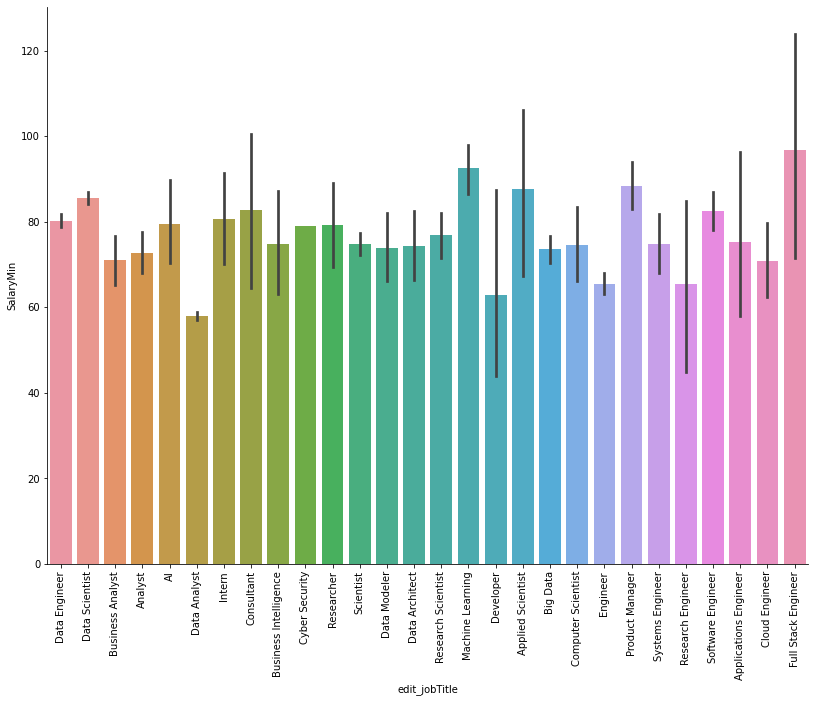

In [20]:
#plot salary info
import seaborn as sns

uniqueJobTitles=FDSword.edit_jobTitle.unique()
print(uniqueJobTitles)
print((len(uniqueJobTitles)))
# sns.set(rc={'figure.figsize':(30,10)})
mini =sns.catplot(x="edit_jobTitle",y="SalaryMin",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
mini.set_xticklabels(rotation=90)
#plt.legend(labels=uniqueJobTitles);

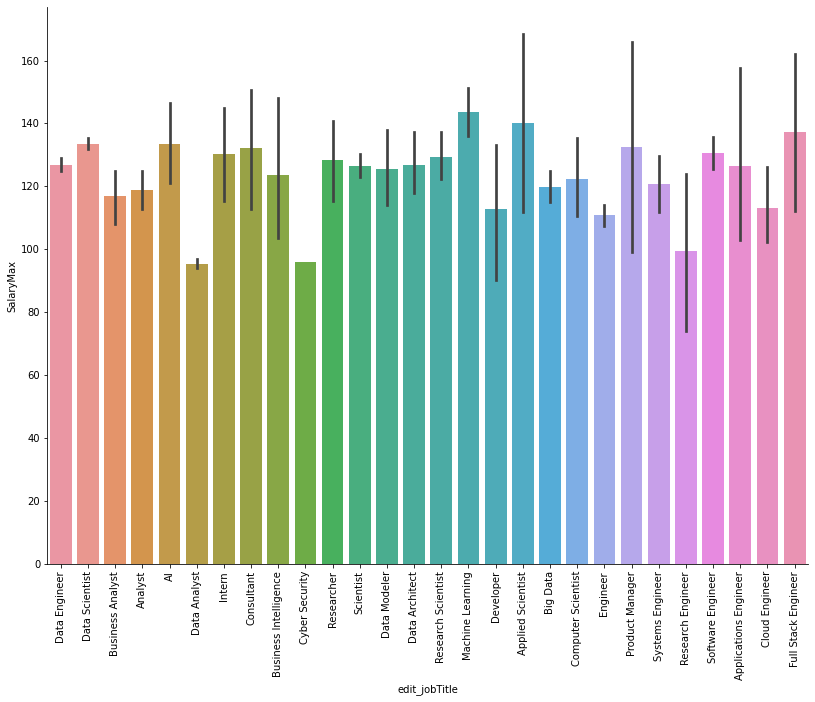

In [21]:
maxi =sns.catplot(x="edit_jobTitle",y="SalaryMax",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
maxi.set_xticklabels(rotation=90);

In [22]:
#fix state info
def state(x):
    if x=="Florida":
        x="FL"
    if x==' CO':
        x="CO"
    if x==" NM":
        x="NM"
    if x==" CA":
        x="CA"
    if x==" NY":
        x="NY"
    if x==" WA":
        x="WA"
    if x==" UT":
        x="UT"
    if x==" TX":
        x="TX"        
    if x==" FL":
        x="FL"
    else:
        x=x
    return x
        
FDSword['State']=FDSword['State'].apply(lambda x: state(x))

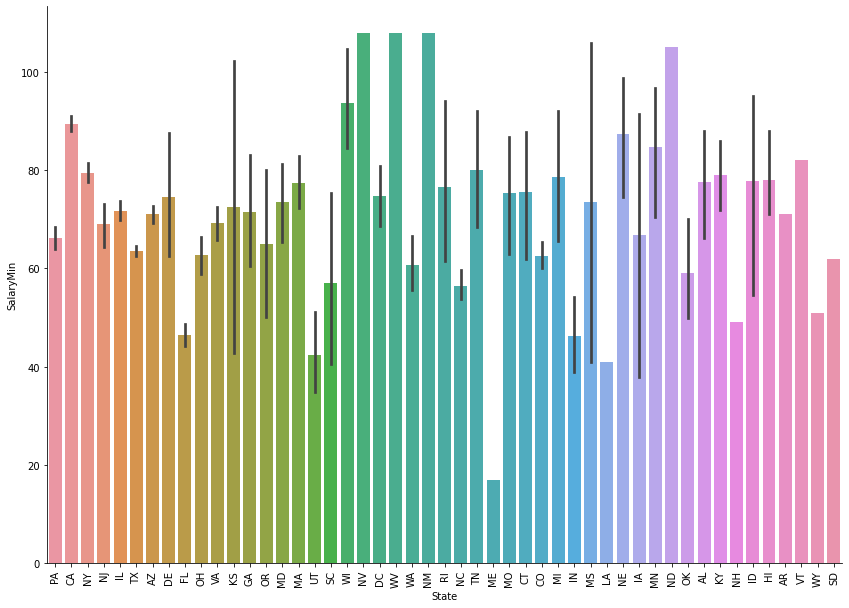

In [23]:
miniState =sns.catplot(x="State",y="SalaryMin",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
miniState.set_xticklabels(rotation=90);

In [24]:
uniqueState=FDSword.State.unique()
print((uniqueState))
print((len(uniqueState)))

['PA' 'CA' 'NY' 'NJ' 'IL' 'TX' 'AZ' 'DE' 'FL' 'OH' 'VA' 'KS' 'GA' 'OR'
 'MD' 'MA' 'UT' 'SC' 'WI' 'NV' 'DC' 'WV' 'WA' 'NM' 'RI' 'NC' 'TN' 'ME'
 'MO' 'CT' 'CO' 'MI' nan 'IN' 'MS' 'LA' 'NE' 'IA' 'MN' 'ND' 'OK' 'AL' 'KY'
 'NH' 'ID' 'HI' 'AR' 'VT' 'WY' 'SD']
50


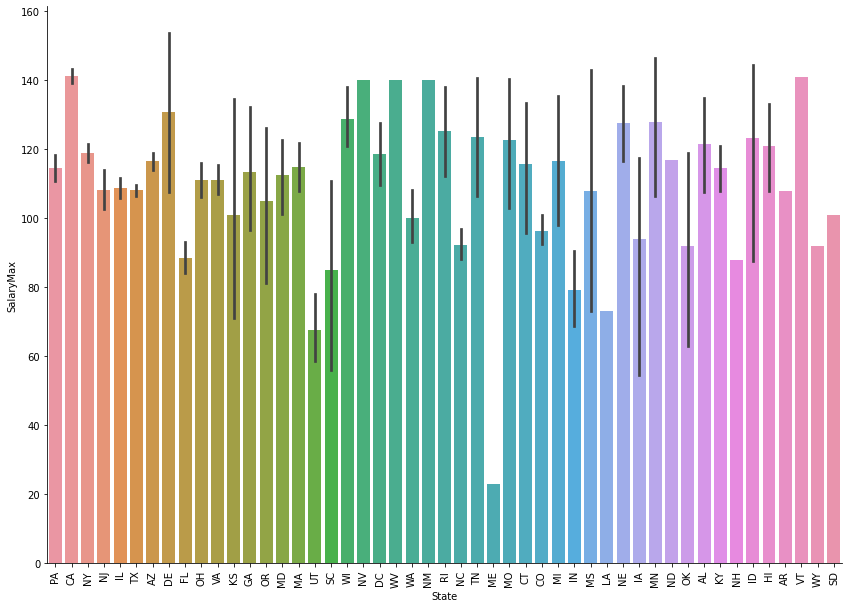

In [25]:
maxiState =sns.catplot(x="State",y="SalaryMax",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
maxiState.set_xticklabels(rotation=90);

In [26]:
profileJT = pp.ProfileReport(FDSword.edit_jobTitle, title = "Pandas Profiling Report", explorative = True)

profileJT

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Data Engineer


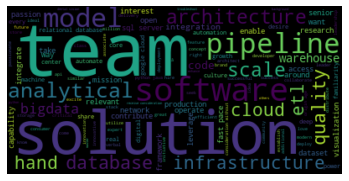



Data Scientist


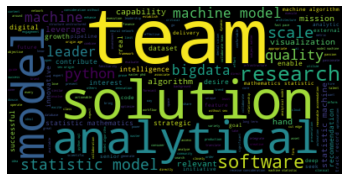



Business Analyst


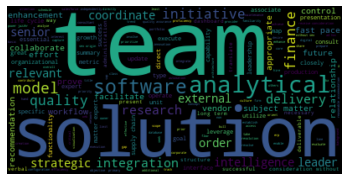



Analyst


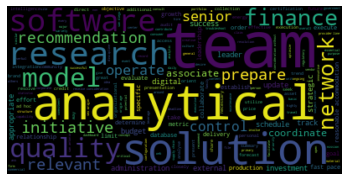



Data Analyst


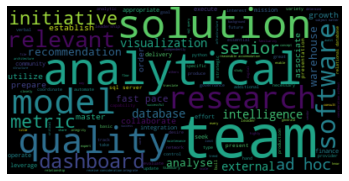

In [38]:
#job title word clouds
from wordcloud import WordCloud
#collocations=False
# filterList=[]
def fun(x):
    if x is None:
        return ""
    wordList.append(x)
    
jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'Data Analyst']

for job in jt:
    wordList=[]
    FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))   
    abc=" ".join(wordList)
    wordcloud = WordCloud().generate(abc)
    # Display the generated image:      
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    print(job)
    plt.show()
#     words=pd.Series(abc.split())
#     print(f'Top 20 words for {job} are \n{words.value_counts().sort_values(ascending=False).head(20)}')
#     filterList.append(words.value_counts().sort_values(ascending=False).head(25))
    
    print("\n")

# print(filterList)
    

Top 20 words for Data Engineer are 
team              4421
solution          2543
sql               1933
pipeline          1911
database          1775
cloud             1701
model             1624
python            1574
software          1552
aws               1308
warehouse         1280
architecture      1149
spark             1041
etl               1036
bigdata           1032
quality            998
infrastructure     950
analytical         941
stream             736
scale              736

Top 20 words for Data Scientist are 
team             8976
model            7871
statistic        5891
machine          5127
solution         3787
analytical       3469
research         3179
python           2830
algorithm        2138
r                2012
sql              1981
software         1924
visualization    1458
ai               1441
mathematics      1369
mine             1154
scale            1147
collaborate      1139
leadership       1120
database         1112


Top 20 words for Business Analyst are 
team            5851
solution        4080
analytical      2939
software        1736
quality         1111
model           1046
sql             1023
excel            834
initiative       833
finance          805
microsoft        758
senior           735
strategic        719
delivery         692
integration      691
coordinate       684
goal             682
relationship     677
collaborate      659
salesforce       658

Top 20 words for Analyst are 
team          2721
analytical    1518
solution      1230
research       830
model          803
software       707
quality        614
finance        512
excel          470
microsoft      454
statistic      438
sql            432
network        425
control        410
budget         398
origin         395
prepare        393
initiative     380
credit         371
database       370

Top 20 words for Data Analyst are 
team             6360
analytical       4363
sql              2822
solution         2811
quality          2764
database         2440
statistic        2425
model            2172
research         1669
software         1468
excel            1424
visualization    1134
microsoft        1121
query            1088
tableau          1011
dashboard         998
senior            941
master            932
python            929
trend             924

In [28]:
#used for testing
# from wordcloud import WordCloud
# #collocations=False
# test = pd.read_csv("test.csv")
# def fun(x):
#     if x is None:
#         return ""
#     wordList.append(x)
    
# jt=['Data Engineer']

# for job in jt:
#     wordList=[]
#     FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))  
#     abc=" ".join(wordList)
#     wordcloud = WordCloud().generate(abc)
#     # Display the generated image:      
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis("off")
#     print(job)
#     plt.show()
#     testing=[w for w in abc.split() if 'scala' == w ]
#     print(len(testing))
#     words=pd.Series(abc.split())
#     print(words)
#     print(words.value_counts().sort_values(ascending=False).head(20))
    
#     print("\n")

In [29]:
# remote, part-time, temp, senior, and junior functions
def remote(x):
    x=x.lower()
    if "remote" in x:
        r=1
    else:
        r=0
    return r

def part(x):
    x=x.lower()
    if "part-time" in x or "part time" in x:
        r=1
    else:
        r=0
    return r

def temp(x):
    x=x.lower()
    if "temp" in x:
        r=1
    else:
        r=0
    return r

def senior(x):
    x=x.lower()
    if "senior" in x or "sr" in x:
        r=1
    else:
        r=np.nan
    return r
def junior(x):
    x=x.lower()
    if "junior" in x or "jr" in x:
        r=1
    else:
        r=np.nan
    return r

        

#Senior = x[16]
#sen= x[23]
FullDataSet['remote']=FullDataSet['Job Description'].dropna().apply(lambda x: remote(x))
FullDataSet['part-time']=FullDataSet['Job Description'].dropna().apply(lambda x: part(x))
FullDataSet['temp']=FullDataSet['Job Description'].dropna().apply(lambda x: temp(x))
FullDataSet['sen']=FullDataSet['Job Description'].dropna().apply(lambda x: senior(x))
FullDataSet['jun']=FullDataSet['Job Description'].dropna().apply(lambda x: junior(x))
FullDataSet['Senior'].fillna(FullDataSet['sen'], inplace=True)
FullDataSet['Junior'].fillna(FullDataSet['jun'], inplace=True)

In [39]:
print(FullDataSet['remote'].sum())
print(FullDataSet['part-time'].sum())
print(FullDataSet['temp'].sum())
print(FullDataSet['Senior'].sum())
print(FullDataSet['Junior'].sum())

1299.0
252.0
1042.0
4012.0
717.0


In [31]:
#used for testing
#FullDataSet[FullDataSet['jun']==1]

Job Title  \
8665   Senior Analyst, Business Intelligence (Looker BI)   
8685                                    Business Analyst   
8733                                    Business Analyst   
8768                                    Business Analyst   
8862                                    Business Analyst   
...                                                  ...   
26922                           Senior Big Data Engineer   
26936            Principal Data Scientist - R&D Oncology   
26940  Senior Scientist - Statistician (Product Integ...   
26944                                     Data Scientist   
27037         Scientist - Early Respiratory & Immunology   

                                         Job Description  \
8665   CB Insights has millions of readers, hundreds ...   
8685   Job Description\nMemo is: The manager is looki...   
8733   Job Description\nDescription\n\nWe are hiring ...   
8768   Junior Sales Representative\n\nVela is a leadi...   
8862   Job Description\nJob Summary:\nLooking for hig...   
...                                                  ...   
26922  Do you want to be part of the transformation t...   
26936  Job Description / Capsule\n\nThe Machine Learn...   
26940  British American Tobacco\nReynolds American In...   
26944  The Data Scientist position is a full-time emp...   
27037  Are you a passionate Scientist thriving to mak...   

                           Company Name           Location           City  \
8665                        CB Insights       New York, NY       New York   
8685         Russell Tobin & Associates    Jersey City, NJ    Jersey City   
8733                         ConsultAdd       New York, NY       New York   
8768                       Options City       New York, NY       New York   
8862   Staffigo Technical Services, LLC       New York, NY       New York   
...                                 ...                ...            ...   
26922                             GEICO    Chevy Chase, MD    Chevy Chase   
26936                       AstraZeneca       New York, NY       New York   
26940                 Reynolds American  Winston-Salem, NC  Winston-Salem   
26944                             Zovio       Chandler, AZ       Chandler   
27037                       AstraZeneca   Gaithersburg, MD   Gaithersburg   

      State     Remote          Size  Founded  \
8665     NY  Uncertain  Medium-Small   2009.0   
8685     NJ  Uncertain         Small   2010.0   
8733     NY  Uncertain         Small      NaN   
8768     NY  Uncertain   SizeUnknown      NaN   
8862     NY  Uncertain         Small   2008.0   
...     ...        ...           ...      ...   
26922    MD        Yes    Very Large   1936.0   
26936    NY  Uncertain    Very Large   1913.0   
26940    NC  Uncertain         Large   1875.0   
26944    AZ  Uncertain  Medium-Large   2004.0   
27037    MD  Uncertain    Very Large   1913.0   

                                    Industry  ...  Junior  Senior   DF  \
8665   Enterprise Software Network Solutions  ...     1.0     NaN  DF1   
8685                    Staffing Outsourcing  ...     1.0     NaN  DF1   
8733                             IT Services  ...     1.0     NaN  DF1   
8768                                     NaN  ...     1.0     NaN  DF1   
8862                             IT Services  ...     1.0     1.0  DF1   
...                                      ...  ...     ...     ...  ...   
26922                     Insurance Carriers  ...     1.0     1.0   DS   
26936              Biotech & Pharmaceuticals  ...     1.0     1.0   DS   
26940        Consumer Products Manufacturing  ...     1.0     1.0   DS   
26944                Colleges & Universities  ...     1.0     NaN   DS   
27037              Biotech & Pharmaceuticals  ...     1.0     NaN   DS   

                                     edit_jobDescription     edit_jobTitle  \
8665   cb   million reader hundred thousand prospect ...  Business Analyst   
8685       memo       businessproduct         

In [32]:
cities=pd.DataFrame(FullDataSet['City'].value_counts())
cities.head(50)

City
New York            1780
San Diego            871
Austin               806
Chicago              794
Houston              706
San Antonio          631
Seattle              626
Los Angeles          525
San Francisco        491
Philadelphia         475
Dallas               426
Phoenix              422
San Jose             298
Denver               247
Jacksonville         217
Sunnyvale            201
Irving               198
Salt Lake City       188
Santa Clara          176
Columbus             171
New York City        160
Tempe                148
Mountain View        143
Plano                142
Fort Worth           131
Menlo Park           115
Redmond              115
Palo Alto             98
Bellevue              95
Boulder               90
Scottsdale            89
Charlotte             84
Tampa                 84
Redwood City          84
Burbank               81
Wilmington            73
El Segundo            70
Lehi                  69
Orlando               64
Jersey City           58
Santa Monica          58
Miami                 56
San Mateo             53
Chandler              51
Arlington             51
Glendale              50
Brooklyn              49
Santa Clara Valley    48
Cambridge             48
Fremont               47

In [33]:
#Bring in cost of living data
tables= pd.read_html('https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020&region=021', header=0)
cost_living=tables[1]
def splitter(x, i):
    return x.split(',')[i]
cost_living=cost_living[cost_living.City.str.contains("United States")] 
cost_living.reset_index(drop=True, inplace=True)
cost_living["Rank"]=cost_living.index+1
cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
cost_living["Country"]=cost_living.City.apply(lambda x: splitter(x,2))
cost_living["City"]=cost_living.City.apply(lambda x: splitter(x,0))
cost_living.count()
cost_living

<ipython-input-33-680448283021>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["Rank"]=cost_living.index+1
<ipython-input-33-680448283021>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
<ipython-input-33-680448283021>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Rank              City  Cost of Living Index  Rent Index  \
0      1          New York                100.00      100.00   
1      2     San Francisco                 91.51      115.58   
2      3         Anchorage                 91.36       38.94   
3      4          Honolulu                 89.70       63.03   
4      5          Brooklyn                 88.82       80.49   
5      6        Washington                 87.74       78.18   
6      7           Oakland                 86.51       79.55   
7      8           Seattle                 85.77       65.70   
8      9            Boston                 82.88       74.47   
9     10          Bellevue                 82.18       63.24   
10    11           Chicago                 80.18       58.64   
11    12          Sarasota                 79.26       46.44   
12    13      Philadelphia                 78.84       46.87   
13    14          San Jose                 78.64       83.34   
14    15          Portland                 78.63       49.42   
15    16       New Orleans                 78.46       41.29   
16    17        Sacramento                 77.00       46.21   
17    18       Minneapolis                 76.70       45.26   
18    19       Los Angeles                 76.55       72.90   
19    20            Albany                 75.44       33.00   
20    21      Jacksonville                 74.57       33.58   
21    22         Baltimore                 74.29       42.61   
22    23         San Diego                 74.22       66.83   
23    24             Miami                 74.16       57.56   
24    25           Buffalo                 73.92       28.28   
25    26           Atlanta                 73.89       46.82   
26    27              Reno                 73.85       38.22   
27    28        Pittsburgh                 73.61       35.86   
28    29            Denver                 73.30       51.98   
29    30         Nashville                 73.19       46.76   
30    31         Charlotte                 72.40       42.37   
31    32            Tucson                 72.12       26.44   
32    33           Olympia                 71.88       41.28   
33    34  Colorado Springs                 70.97       36.00   
34    35            Tacoma                 70.88       41.20   
35    36       Saint Louis                 70.78       28.97   
36    37          Columbus                 70.50       31.39   
37    38           Raleigh                 69.80       36.60   
38    39       Kansas City                 69.17       30.51   
39    40            Dallas                 68.03       47.05   
40    41            Austin                 67.79       52.04   
41    42         Las Vegas                 67.46       36.26   
42    43           Phoenix                 67.41       36.18   
43    44          Richmond                 67.20       33.88   
44    45             Tampa                 67.10       40.83   
45    46        Louisville                 66.72       28.71   
46    47      Indianapolis                 66.34       29.25   
47    48       San Antonio                 65.78       36.50   
48    49           Orlando                 65.70       41.51   
49    50           Houston                 65.13       42.70   
50    51    Salt Lake City                 64.76       36.83   
51    52           Madison                 64.67       38.11   
52    53             Tulsa                 64.28       26.38   
53    54           Detroit                 63.85       37.80   
54    55        Cincinnati                 61.64       33.99   
55    56             Boise                 60.71       34.47   
56    57       Little Rock                 59.76       26.39   
57    58           El Paso                 52.38       22.71   

    Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                           100.00           100.00                  100.00   
1                           103.02            86.91                  